In [1]:
import numpy as np

# DATA from the Pythia simulation - Decay of Z to b-bbar 

# Study of the energy distribution of a weakly decaying B meson

# Path to your file
filename = "B-data.txt"

# Lists to store the data
pdg_codes = []
px = []
py = []
pz = []
E  = []

with open(filename, 'r') as file:
    for line in file:
        # Skip empty lines
        if not line.strip():
            continue
        tokens = line.strip().split()
        if len(tokens) != 5:
            print(f"Skipping malformed line: {line}")
            continue
        pdg, px_, py_, pz_, E_ = tokens
        pdg_codes.append(int(pdg))
        px.append(float(px_))
        py.append(float(py_))
        pz.append(float(pz_))
        E.append(float(E_))

# Convert to numpy arrays for easy further analysis
pdg_codes = np.array(pdg_codes)
px = np.array(px)
py = np.array(py)
pz = np.array(pz)
E  = np.array(E)

print(f"Read {len(pdg_codes)} B hadrons from {filename}")

# Example: print the first 5 entries
for i in range(min(5, len(pdg_codes))):
    print(f"PDG: {pdg_codes[i]}, px: {px[i]:.3f}, py: {py[i]:.3f}, pz: {pz[i]:.3f}, E: {E[i]:.3f}")


Read 99806 B hadrons from B-data.txt
PDG: -521, px: 11.853, py: -26.699, pz: 9.296, E: 31.107
PDG: 521, px: 21.809, py: -6.129, pz: 8.134, E: 24.642
PDG: -531, px: 13.512, py: -11.127, pz: -33.118, E: 37.842
PDG: -511, px: -21.022, py: 7.937, pz: 11.358, E: 25.726
PDG: 511, px: -2.316, py: 19.252, pz: -29.780, E: 35.926


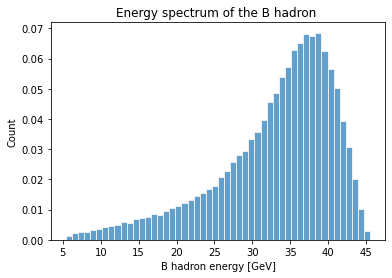

In [2]:
import matplotlib.pyplot as plt

plt.hist(E, bins=50, density=True, edgecolor='white', alpha=0.7)
plt.xlabel("B hadron energy [GeV]")
plt.ylabel("Count")
plt.title("Energy spectrum of the B hadron ")
plt.show()


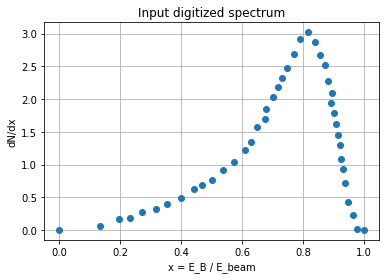

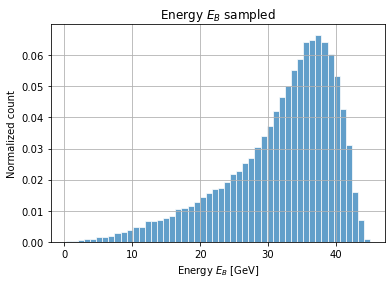

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

mB = 5.27934 #GeV
N_events = 100_000  # Big number of events 
E_beam = 45.6 #GeV

data = np.genfromtxt("Default Dataset(1).txt", delimiter=';', dtype=str)
data = np.char.replace(data, ',', '.').astype(float)
    
x = data[:, 0]  # EB / E_beam
y = data[:, 1]  # 1/N dN/dX

# I'm adding the (0.0) and (1,0) points I missed in the data digitalization

x = np.insert(x, 0, 0)
y = np.insert(y, 0, 0)

x = np.insert(x, 0, 1)
y = np.insert(y, 0, 0)

plt.plot(x, y,'o')
plt.xlabel("x = E_B / E_beam")
plt.ylabel("dN/dx")
plt.title("Input digitized spectrum")
plt.grid(True)
plt.show()

# y = np.clip(y, 0, None)
pdf_func = interp1d(x, y, kind='linear', bounds_error=False, fill_value=0)

# Inverse transform sampling
x_dense = np.linspace(x.min(), x.max(), 1000)
y_dense = pdf_func(x_dense)
cdf = np.cumsum(y_dense)
cdf = cdf / cdf[-1]  # Normalize

# Invert the CDF
inverse_cdf = interp1d(cdf, x_dense, bounds_error=False, fill_value=(x_dense[0], x_dense[-1]))
u = np.random.uniform(0, 1, size=N_events)
x_sampled = inverse_cdf(u)

EB_sampled = x_sampled * E_beam

plt.hist(EB_sampled, bins = 50, density=True, edgecolor='white', alpha=0.7)
plt.xlabel(r'Energy $E_B$ [GeV]')
plt.ylabel('Normalized count')
plt.title(r'Energy $E_{B}$ sampled')
plt.grid(True)
plt.show()




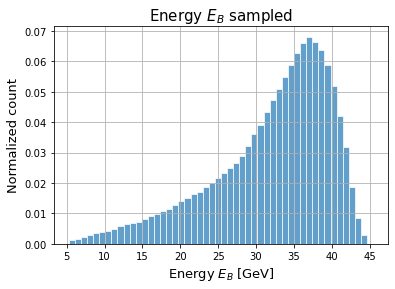

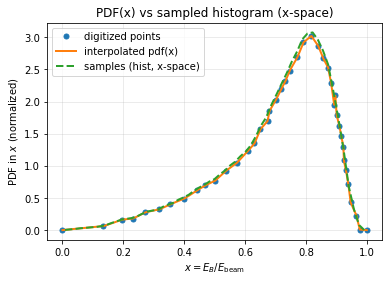

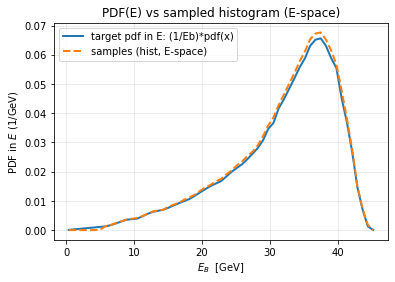

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import cumulative_trapezoid

# --- inputs ---
mB = 5.27934       # GeV (not used here, just fyi)
N_events = 1_000_000
E_beam = 45.6  # GeV (Z pole ~ mZ/2 ≈ 45.6 GeV)

oversampled_factor = 1.2
N = int(oversampled_factor*N_events)

raw = np.genfromtxt("Default Dataset(1).txt", delimiter=';', dtype=str)
raw = np.char.replace(raw, ',', '.').astype(float)
x = raw[:,0]      # x = EB / E_beam
y = raw[:,1]      # (1/N) dN/dx  (approx, from digitization)

# Add endpoints, then sort by x
x = np.concatenate([x, [0.0, 1.0]])
y = np.concatenate([y, [0.0, 0.0]])
order = np.argsort(x)
x, y = x[order], y[order]

# Clip negatives (can appear from digitization)
y = np.clip(y, 0.0, None)

# Build a continuous, nonnegative pdf(x)
pdf = interp1d(x, y, kind='linear', bounds_error=False, fill_value=0.0)

# Dense grid on [0,1]
x_dense = np.linspace(0.0, 1.0, 2000)
y_dense = np.clip(pdf(x_dense), 0.0, None)

# CDF via trapezoid; normalize to 1
cdf = cumulative_trapezoid(y_dense, x_dense, initial=0.0)
if cdf[-1] == 0:
    raise RuntimeError("Digitized PDF integrates to ~0. Check input data.")
cdf /= cdf[-1]

# Invert CDF: u in [0,1] -> x
u = np.random.random(size=N)
# Ensure CDF is strictly increasing for interpolation
# (if there are flats, np.interp still works)
x_sampled = np.interp(u, cdf, x_dense)

# Convert to energies if needed
EB_raw = x_sampled * E_beam

EB_valid = EB_raw[EB_raw > mB]
EB_sampled = EB_valid[:N]  # select first N valid ones

plt.hist(EB_sampled, bins = 50, density=True, edgecolor='white', alpha=0.7)
plt.xlabel(r'Energy $E_B$ [GeV]', fontsize = 13)
plt.ylabel('Normalized count', fontsize = 13)
plt.title(r'Energy $E_{B}$ sampled', fontsize = 15)
plt.grid(True)
plt.savefig("EB histogram", dpi=300, bbox_inches='tight')
plt.show()

# --- diagnostics: check sampling in x-domain (no Jacobian confusion) ---
bins_x = np.linspace(0, 1, 60)
hist_x, edges = np.histogram(x_sampled, bins=bins_x, density=True)
centers = 0.5*(edges[1:]+edges[:-1])

plt.plot(x, y, 'o', ms=5, label="digitized points")
plt.plot(x_dense, y_dense, '-', lw=2, label="interpolated pdf(x)")
plt.plot(centers, hist_x, '--', lw=2, label="samples (hist, x-space)")
plt.xlabel(r"$x = E_B/E_{\rm beam}$")
plt.ylabel(r"PDF in $x$ (normalized)")
plt.grid(True, alpha=0.3); plt.legend(); plt.title("PDF(x) vs sampled histogram (x-space)")
plt.savefig("Digitized data comparison", dpi=300, bbox_inches='tight')
plt.show()

# --- optional: plot in E with correct units ---
# Note: pdf_E(E) = (1/E_beam) * pdf_x(E/E_beam)
bins_E = np.linspace(0, E_beam, 60)
hist_E, edges_E = np.histogram(EB_sampled, bins=bins_E, density=True)
centers_E = 0.5*(edges_E[1:]+edges_E[:-1])
pdf_E = (1.0/E_beam) * np.clip(pdf(centers_E/E_beam), 0.0, None)

plt.plot(centers_E, pdf_E, lw=2, label="target pdf in E: (1/Eb)*pdf(x)")
plt.plot(centers_E, hist_E, '--', lw=2, label="samples (hist, E-space)")
plt.xlabel(r"$E_B$  [GeV]"); plt.ylabel(r"PDF in $E$ (1/GeV)")
plt.grid(True, alpha=0.3); plt.legend(); plt.title("PDF(E) vs sampled histogram (E-space)")
plt.show()


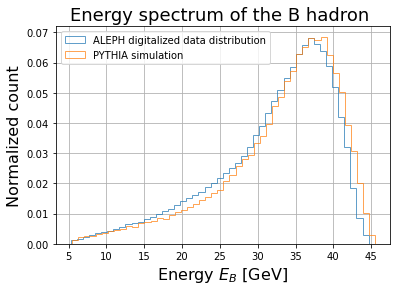

In [5]:
plt.hist(EB_sampled, bins = 50, density=True, alpha=0.7, label = "ALEPH digitalized data distribution", histtype="step")
plt.hist(E, bins = 50, density=True, alpha=0.7, label = "PYTHIA simulation", histtype="step")
plt.xlabel(r'Energy $E_B$ [GeV]', fontsize = 16)
plt.ylabel('Normalized count', fontsize = 16)
plt.title("Energy spectrum of the B hadron ", fontsize = 18)
plt.grid(True)
plt.legend(fontsize = 10)
plt.show()



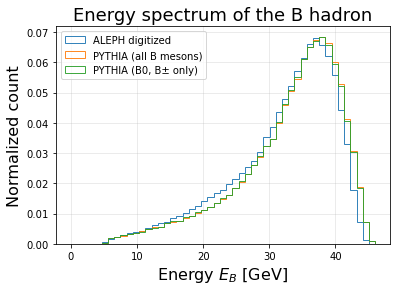

Total B hadrons: 99806, kept (B0/B±): 89834


In [6]:
# ALEPH considers in principle only B0 and B+- (non-strange B mesons), while the Pythia program also includes the Bs
# PDG codes B+ 521, B0 511, B0s 531

import numpy as np
import matplotlib.pyplot as plt

# Absolute PDG codes to include antiparticles
pdg_abs = np.abs(pdg_codes)

# Keep only B0 (511) and B+ (521)
KEEP_PDG = {511, 521}
mask_species = np.isin(pdg_abs, list(KEEP_PDG))
E_filtered = E[mask_species]

# Common bins for fair comparison
bins = np.linspace(0, 46, 50)

plt.hist(EB_sampled, bins=bins, density=True, histtype="step",
         alpha=0.9, label="ALEPH digitized")
plt.hist(E, bins=bins, density=True, histtype="step",
         alpha=0.9, label="PYTHIA (all B mesons)")
plt.hist(E_filtered, bins=bins, density=True, histtype="step",
         alpha=0.9, label="PYTHIA (B0, B± only)")

plt.xlabel(r'Energy $E_B$ [GeV]', fontsize=16)
plt.ylabel('Normalized count', fontsize=16)
plt.title("Energy spectrum of the B hadron", fontsize=18)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.show()

print(f"Total B hadrons: {len(E)}, kept (B0/B±): {len(E_filtered)}")






Target: peak=37.08, width=9.31, tail=0.2386
Best: VIS_MEAN=0.984, A=0.200
Current: peak=37.08, width=9.24, tail=0.2262

--- Comparison to ALEPH ---
Peak  : 37.08 vs 37.08  (Δ = +0.000 GeV)
Width : 9.24 vs 9.31  (Δ = -0.063 GeV)
Tail>38: 0.2262 vs 0.2386  (Δ = -0.0124)


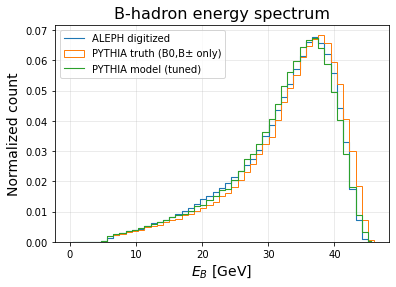

In [18]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(12345)
bins = np.linspace(0, 46, 50)
cent = 0.5 * (bins[1:] + bins[:-1])

# -------------------------------------------------
# Helper functions
# -------------------------------------------------
def hist_density(x, w=None):
    c, _ = np.histogram(x, bins=bins, weights=w)
    Nw = np.sum(w) if w is not None else len(x)
    return c / (Nw * np.diff(bins))

def eff_logistic(E, e_min=0.82, e_max=1.0, E0=40.5, w=9):
    return e_min + (e_max - e_min) / (1.0 + np.exp((E - E0) / w))

def simulate(VIS_MEAN, A, VIS_SIGM=0.03, B=0.028, E0=40.5, w=9, e_min=0.82):
    vis_frac = np.clip(rng.normal(VIS_MEAN, VIS_SIGM, size=E_filtered.size), 0.6, 1.0)
    E_vis  = E_filtered * vis_frac
    sigma  = np.sqrt(A**2 + (B * np.sqrt(np.clip(E_vis, 0, None)))**2)
    E_reco = np.clip(rng.normal(E_vis, sigma), 0, None)
    w_acc  = eff_logistic(E_reco, e_min=e_min, e_max=1.0, E0=E0, w=w)
    d_mc   = hist_density(E_reco, w=w_acc)
    peak_mc  = cent[np.argmax(d_mc)]
    width_mc = np.sqrt(np.average((cent - peak_mc) ** 2, weights=d_mc))
    tail_mc  = np.trapz(d_mc[cent > 38], cent[cent > 38])
    return d_mc, peak_mc, width_mc, tail_mc

# -------------------------------------------------
# Targets from ALEPH digitized data
# -------------------------------------------------
d_data = hist_density(EB_sampled)
peak_target  = cent[np.argmax(d_data)]
width_target = np.sqrt(np.average((cent - peak_target) ** 2, weights=d_data))
tail_target  = np.trapz(d_data[cent > 38], cent[cent > 38])

print(f"Target: peak={peak_target:.2f}, width={width_target:.2f}, tail={tail_target:.4f}")

# -------------------------------------------------
# Minimal tuning loop for VIS_MEAN and A
# -------------------------------------------------
VIS_SIGM = 0.03
A_lo, A_hi = 0.10, 0.20
VIS_lo, VIS_hi = 0.95, 0.99
best = None

for _ in range(20):  # limit iterations
    VIS_try = 0.5 * (VIS_lo + VIS_hi)
    A_try   = 0.5 * (A_lo + A_hi)
    d_mc, pk, wd, tl = simulate(VIS_MEAN=VIS_try, A=A_try, VIS_SIGM=VIS_SIGM)
    
    score = abs(pk - peak_target) + abs(wd - width_target)
    if best is None or score < best[0]:
        best = (score, VIS_try, A_try, pk, wd, tl, d_mc)
    
    if abs(pk - peak_target) < 0.01 and abs(wd - width_target) < 0.01:
        break
    
    if pk < peak_target:
        VIS_lo = VIS_try
    else:
        VIS_hi = VIS_try
    if wd < width_target:
        A_lo = A_try
    else:
        A_hi = A_try

# -------------------------------------------------
# Best result
# -------------------------------------------------
_, VIS_star, A_star, pk, wd, tl, d_mc_best = best
print(f"Best: VIS_MEAN={VIS_star:.3f}, A={A_star:.3f}")
print(f"Current: peak={pk:.2f}, width={wd:.2f}, tail={tl:.4f}")

# Print differences
print("\n--- Comparison to ALEPH ---")
print(f"Peak  : {pk:.2f} vs {peak_target:.2f}  (Δ = {pk - peak_target:+.3f} GeV)")
print(f"Width : {wd:.2f} vs {width_target:.2f}  (Δ = {wd - width_target:+.3f} GeV)")
print(f"Tail>38: {tl:.4f} vs {tail_target:.4f}  (Δ = {tl - tail_target:+.4f})")

# -------------------------------------------------
# Plotting
# -------------------------------------------------
plt.step(cent, d_data, where='mid', label="ALEPH digitized", lw = 1.1)
plt.hist(E_filtered, bins=bins, density=True, histtype="step", label="PYTHIA truth (B0,B± only)")
plt.step(cent, d_mc_best, where='mid', label="PYTHIA model (tuned)", lw = 1.1)
plt.xlabel(r"$E_B$ [GeV]", fontsize=14)
plt.ylabel("Normalized count", fontsize=14)
plt.title("B-hadron energy spectrum", fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()



=== Summary vs ALEPH ===
Peak   : 37.08 vs 37.08  (Δ = +0.000 GeV)
Width  : 9.23 vs 9.31  (Δ = -0.080 GeV)
Tail>38: 0.2272 vs 0.2386  (Δ = -0.0114)
Entries: truth=89834, reco (weighted sum)=85041.8
Reconstruction Efficiency =0.946654712731116


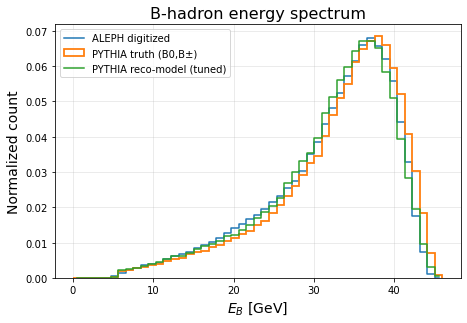

In [16]:
import numpy as np
import matplotlib.pyplot as plt

rng  = np.random.default_rng(12345)
bins = np.linspace(0, 46, 50)
cent = 0.5 * (bins[1:] + bins[:-1])

# --- keep only non‑strange B mesons (B0,B±), incl. antiparticles ---
pdg_abs = np.abs(pdg_codes)
mask_species = np.isin(pdg_abs, [511, 521])
E_filtered = E[mask_species]

def hist_density(x, w=None):
    c, _ = np.histogram(x, bins=bins, weights=w)
    Nw = np.sum(w) if w is not None else len(x)
    return c / (Nw * np.diff(bins))

def eff_logistic(E, e_min=0.83, e_max=1.0, E0=40.5, w=9):
    return e_min + (e_max - e_min) / (1.0 + np.exp((E - E0)/w))

def simulate_reco(E_truth,
                  VIS_MEAN=0.984, VIS_SIGM=0.03,
                  A=0.205, B=0.028,    # <-- tweaked A
                  E0=40.5, w=9, e_min=0.83):  # <-- tweaked e_min
    vis = np.clip(rng.normal(VIS_MEAN, VIS_SIGM, size=E_truth.size), 0.6, 1.0)
    E_vis  = E_truth * vis
    sigma  = np.sqrt(A**2 + (B*np.sqrt(np.clip(E_vis,0,None)))**2)
    E_reco = np.clip(rng.normal(E_vis, sigma), 0, None)
    w_acc  = eff_logistic(E_reco, e_min=e_min, e_max=1.0, E0=E0, w=w)
    return E_reco, w_acc

# --- targets from ALEPH (digitized) ---
d_data = hist_density(EB_sampled)
peak_data  = cent[np.argmax(d_data)]
width_data = np.sqrt(np.average((cent - peak_data)**2, weights=d_data))
tail_data  = np.trapz(d_data[cent > 38], cent[cent > 38])

# --- PYTHIA truth (B0,B±) ---
d_truth = hist_density(E_filtered)

# --- PYTHIA reco-model (fixed knobs) ---
E_reco, w_acc = simulate_reco(E_filtered)
d_reco = hist_density(E_reco, w=w_acc)
peak_reco  = cent[np.argmax(d_reco)]
width_reco = np.sqrt(np.average((cent - peak_reco)**2, weights=d_reco))
tail_reco  = np.trapz(d_reco[cent > 38], cent[cent > 38])

# --- summary ---
print("=== Summary vs ALEPH ===")
print(f"Peak   : {peak_reco:.2f} vs {peak_data:.2f}  (Δ = {peak_reco - peak_data:+.3f} GeV)")
print(f"Width  : {width_reco:.2f} vs {width_data:.2f}  (Δ = {width_reco - width_data:+.3f} GeV)")
print(f"Tail>38: {tail_reco:.4f} vs {tail_data:.4f}  (Δ = {tail_reco - tail_data:+.4f})")
print(f"Entries: truth={E_filtered.size}, reco (weighted sum)={w_acc.sum():.1f}")
print(f"Reconstruction Efficiency ={w_acc.sum()/E_filtered.size}")

# --- plot ---
plt.figure(figsize=(6.6, 4.6))
plt.step(cent, d_data,  where='mid', label="ALEPH digitized")
plt.hist(E_filtered, bins=bins, density=True, histtype="step", label="PYTHIA truth (B0,B±)", linewidth = 1.8)
plt.step(cent, d_reco, where='mid', label="PYTHIA reco-model (tuned)")
plt.xlabel(r"$E_B$ [GeV]", fontsize=14); plt.ylabel("Normalized count", fontsize=14)
plt.title("B-hadron energy spectrum", fontsize=16)
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.savefig("ALEPH-Pythia comparison", dpi=300, bbox_inches='tight'); plt.show()


=== Summary vs ALEPH ===
Peak   : 37.08 vs 37.08  (Δ = +0.000 GeV)
Width  : 9.07 vs 9.31  (Δ = -0.235 GeV)
Tail>38: 0.2284 vs 0.2386  (Δ = -0.0102)
Entries: truth=89834, reco (weighted sum)=84577.8


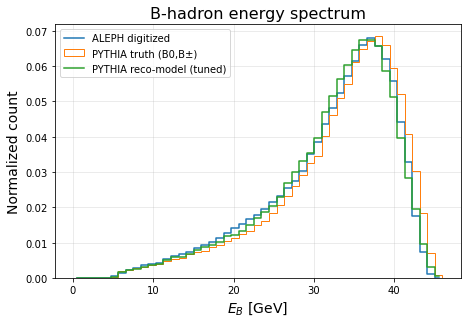

In [12]:
import numpy as np
import matplotlib.pyplot as plt

rng  = np.random.default_rng(12345)
bins = np.linspace(0, 46, 50)
cent = 0.5 * (bins[1:] + bins[:-1])

# --- keep only non‑strange B mesons (B0,B±), incl. antiparticles ---
pdg_abs = np.abs(pdg_codes)
mask_species = np.isin(pdg_abs, [511, 521])
E_filtered = E[mask_species]

def hist_density(x, w=None):
    c, _ = np.histogram(x, bins=bins, weights=w)
    Nw = np.sum(w) if w is not None else len(x)
    return c / (Nw * np.diff(bins))

def eff_logistic(E, e_min=0.83, e_max=1.0, E0=40.5, w=9):
    return e_min + (e_max - e_min) / (1.0 + np.exp((E - E0)/w))

def u_shaped_eff(E, Emin=12.0, w_lo=3.0, Ehi=40.5, w_hi=9.0, e_min=0.83, e_max=1.0):
    up   = 1.0 / (1.0 + np.exp(-(E - Emin)/w_lo))       # rises from low E
    down = 1.0 / (1.0 + np.exp( (E - Ehi)/w_hi))        # falls at high E
    eps  = e_min + (e_max - e_min) * (up * down)
    return np.clip(eps, 0.0, 1.0)


def simulate_reco(E_truth,
                  VIS_MEAN=0.984, VIS_SIGM=0.03,
                  A=0.205, B=0.028,    # <-- tweaked A
                  E0=40.5, w=9, e_min=0.83):  # <-- tweaked e_min
    vis = np.clip(rng.normal(VIS_MEAN, VIS_SIGM, size=E_truth.size), 0.6, 1.0)
    E_vis  = E_truth * vis
    sigma  = np.sqrt(A**2 + (B*np.sqrt(np.clip(E_vis,0,None)))**2)
    E_reco = np.clip(rng.normal(E_vis, sigma), 0, None)
    w_acc = u_shaped_eff(E_reco)
    return E_reco, w_acc

# --- targets from ALEPH (digitized) ---
d_data = hist_density(EB_sampled)
peak_data  = cent[np.argmax(d_data)]
width_data = np.sqrt(np.average((cent - peak_data)**2, weights=d_data))
tail_data  = np.trapz(d_data[cent > 38], cent[cent > 38])

# --- PYTHIA truth (B0,B±) ---
d_truth = hist_density(E_filtered)

# --- PYTHIA reco-model (fixed knobs) ---
E_reco, w_acc = simulate_reco(E_filtered)
d_reco = hist_density(E_reco, w=w_acc)
peak_reco  = cent[np.argmax(d_reco)]
width_reco = np.sqrt(np.average((cent - peak_reco)**2, weights=d_reco))
tail_reco  = np.trapz(d_reco[cent > 38], cent[cent > 38])

# --- summary ---
print("=== Summary vs ALEPH ===")
print(f"Peak   : {peak_reco:.2f} vs {peak_data:.2f}  (Δ = {peak_reco - peak_data:+.3f} GeV)")
print(f"Width  : {width_reco:.2f} vs {width_data:.2f}  (Δ = {width_reco - width_data:+.3f} GeV)")
print(f"Tail>38: {tail_reco:.4f} vs {tail_data:.4f}  (Δ = {tail_reco - tail_data:+.4f})")
print(f"Entries: truth={E_filtered.size}, reco (weighted sum)={w_acc.sum():.1f}")

# --- plot ---
plt.figure(figsize=(6.6, 4.6))
plt.step(cent, d_data,  where='mid', label="ALEPH digitized")
plt.hist(E_filtered, bins=bins, density=True, histtype="step", label="PYTHIA truth (B0,B±)")
plt.step(cent, d_reco, where='mid', label="PYTHIA reco-model (tuned)")
plt.xlabel(r"$E_B$ [GeV]", fontsize=14); plt.ylabel("Normalized count", fontsize=14)
plt.title("B-hadron energy spectrum", fontsize=16)
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()
